# Transformer-based Survival Models

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sklearn.metrics import log_loss
from sksurv.util import Surv
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'torch',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))

dfp = df.to_pandas()
dfp_nn = dfp.dropna()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 1.5.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
torch version: 1.13.1
sksurv version: 0.21.0
sklearn version: 1.2.2
scipy version: 1.13.1


In [221]:
events = dfp_nn["event"].to_numpy().astype(np.float32)
times = dfp_nn["time"].to_numpy().astype(np.float32)
times = np.minimum(10, times)
X_seq = dfp_nn.drop(columns=["time", "event"]).to_numpy()[:,np.newaxis,:].astype(np.float32)

bmi_range = np.linspace(dfp_nn["BMICALC"].min(), dfp_nn["BMICALC"].max(), 50)
earnings_range = np.linspace(dfp_nn["earnings_quantile"].min(), dfp_nn["earnings_quantile"].max(), 50)
sleep_range = np.linspace(dfp_nn["HRSLEEP"].min(), dfp_nn["HRSLEEP"].max(), 50)
age_range = np.linspace(dfp_nn["AGE"].min(), dfp_nn["AGE"].max(), 50)

X_seq = (X_seq - np.min(X_seq, axis = 0)) / (np.max(X_seq, axis = 0) - np.min(X_seq, axis = 0))

X_train, X_test, events_train, events_test, times_train, times_test = train_test_split(X_seq, events, times, test_size=0.2, random_state=0)
X_train, X_val, events_train, events_val, times_train, times_val = train_test_split(X_train, events_train, times_train, test_size=0.2, random_state=0)

n_samples = X_seq.shape[0]
time_steps = X_seq.shape[1]
n_features = X_seq.shape[2]

In [2]:
class SurvivalDataset(Dataset):
    def __init__(self, X, times, events):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.times = torch.tensor(times, dtype=torch.long)
        self.events = torch.tensor(events, dtype=torch.float32)

    def __len__(self):
        return len(self.times)

    def __getitem__(self, idx):
        return self.X[idx], self.times[idx], self.events[idx]

In [3]:
class SurvivalTransformer(nn.Module):
    def __init__(self, input_dim, time_steps, d_model=64, nhead=4, num_layers=2, max_len=12, dropout=0.05):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = self._generate_positional_encoding(time_steps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.pooling = nn.Sequential(
            nn.Flatten(start_dim=1),  # shape: (batch, time_steps * d_model)
            nn.Linear(d_model * time_steps, d_model),  # compress sequence to vector
            nn.ReLU(),
        )
        self.output = nn.Linear(d_model, max_len)  # Output logits per discrete time bin

    def _generate_positional_encoding(self, time_steps, d_model):
        pe = torch.zeros(time_steps, d_model)
        position = torch.arange(0, time_steps).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        x = self.embedding(x)  # (batch, time_steps, d_model)
        x = x + self.positional_encoding.to(x.device)
        x = self.transformer(x)  # (batch, time_steps, d_model)
        x_flat = self.pooling(x)  # (batch, d_model)
        out = self.output(x_flat)  # (batch, max_len)
        return torch.softmax(out, dim=1)  # PMF over discrete survival times

In [4]:
class DiscreteTimeLogLikelihoodLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    
    def forward(self, pred_pmf, times, events):
        log_likelihoods = []
        for i in range(len(times)):
            k = times[i]
            if events[i] == 1:
                log_likelihoods.append(torch.log(pred_pmf[i, k] + self.eps))  # log P(T = t_k)
            else:
                log_likelihoods.append(torch.log(torch.sum(pred_pmf[i, k + 1:]) + self.eps))  # log P(T >= t_k) instead of P(T > t_k) 
        return -torch.mean(torch.stack(log_likelihoods))


class RankingLoss(nn.Module):
    def __init__(self, sigma=0.3):
        super().__init__()
        self.sigma = sigma

    def forward(self, pred, times, events):
        cdf = torch.cumsum(pred, dim=1)
        loss = []
        for i in range(len(times)):
            for j in range(len(times)):
                if times[i] < times[j] and events[i] == 1:
                    t_j = times[j] - 1
                    s_i = 1.0 - cdf[i, t_j]
                    s_j = 1.0 - cdf[j, t_j]
                    loss.append(torch.sigmoid((s_i - s_j) / self.sigma))
        if len(loss) == 0:
            return torch.tensor(0.0, device=pred.device)
        return torch.stack(loss).mean()


In [225]:
np.random.seed(0)
torch.manual_seed(0)

device = "cpu"
model = SurvivalTransformer(input_dim=X_seq.shape[2], time_steps=time_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
likelihood_loss = DiscreteTimeLogLikelihoodLoss()
ranking_loss = RankingLoss()
alpha = 0.2

train_dataset = SurvivalDataset(X_train, times_train, events_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataset = SurvivalDataset(X_val, times_val, events_val)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

train_losses, val_losses = [], []

start_time = time.time()
for epoch in range(8):
    model.train()
    train_loss = 0
    for X_batch, T_batch, E_batch in train_loader:
        X_batch, T_batch, E_batch = X_batch.to(device), T_batch.to(device), E_batch.to(device)

        pred = model(X_batch)
        l_lik = likelihood_loss(pred, T_batch, E_batch)
        l_rank = ranking_loss(pred, T_batch, E_batch)
        loss = l_lik + alpha * l_rank

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)

    val_loss = 0
    with torch.no_grad():
        for X_batch, T_batch, E_batch in val_loader:
            X_batch, T_batch, E_batch = X_batch.to(device), T_batch.to(device), E_batch.to(device)
    
            pred = model(X_batch)
            l_lik = likelihood_loss(pred, T_batch, E_batch)
            l_rank = ranking_loss(pred, T_batch, E_batch)
            loss = l_lik + alpha * l_rank
            
            val_loss += loss.item()
    val_losses.append(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, learning rate: {current_lr:.6f}")

    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.9

print(f"Fitting time: {time.time() - start_time:.2f} seconds")

Epoch 0, train loss: 75.9887, val loss: 16.5758, learning rate: 0.001000
Epoch 1, train loss: 65.4251, val loss: 16.4873, learning rate: 0.000900
Epoch 2, train loss: 65.2331, val loss: 16.5668, learning rate: 0.000810
Epoch 3, train loss: 64.9982, val loss: 16.3953, learning rate: 0.000729
Epoch 4, train loss: 64.8062, val loss: 16.3490, learning rate: 0.000656
Epoch 5, train loss: 64.6640, val loss: 16.2806, learning rate: 0.000590
Epoch 6, train loss: 63.3435, val loss: 15.9538, learning rate: 0.000531
Epoch 7, train loss: 62.6685, val loss: 15.8524, learning rate: 0.000478
Fitting time: 20169.88 seconds


In [228]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    pred = model(X_test_tensor).cpu().numpy()

time_bins = np.arange(12)
pred_time = (pred * time_bins).sum(axis=1)

y_test_struct = Surv.from_arrays(events_test.astype(bool), times_test)
c_index = concordance_index_censored(y_test_struct["event"], y_test_struct["time"], -pred_time)[0]
print(f"C-index: {c_index:.4f}")

pred_surv = 1 - np.cumsum(pred, axis=1)
pred_surv = pred_surv[:,:-1]
time_grid = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9.9])
ibs = integrated_brier_score(y_test_struct, y_test_struct, pred_surv, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = ((events_test == True) & (times_test >= 2) & (times_test < 3)).astype(int)
p_interval = pred_surv[:, 2] - pred_surv[:, 3]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8705
Integrated Brier Score: 0.0393
Log loss for interval [2, 3): 0.0510


In [ ]:
def plot_pdp(model, X, feature_idx, feature_name, value_range, t1, t2, device="cpu"): 
    model.eval()
    X = torch.tensor(X, dtype=torch.float32)
    X = X.to(device)
    seq_len = X.shape[1]
    outputs = []

    for j in np.arange(len(value_range)):
        X_mod = X.clone()
        X_mod[:, :, feature_idx] = j/(len(value_range)-1)
        with torch.no_grad():
            pred = model(X_mod).detach().numpy()
            pred_surv = 1 - np.cumsum(pred, axis=1)
        outputs.append(np.mean(pred_surv[:,t1] - pred_surv[:,t2]))

    plt.figure(figsize=(6, 4))
    plt.plot(value_range, outputs)
    plt.xlabel(feature_name)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"TSM: Partial Dependence Plot for {feature_name}")
    plt.show()

def plot_ale(model, X, feature_idx, feature_name, value_range, t1, t2, device="cpu"): 
    model.eval()
    X = torch.tensor(X, dtype=torch.float32)
    X = X.to(device)
    seq_len = X.shape[1]
    outputs = []
    bin_edges = np.linspace(0.0, 1.0, 51)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        X_mod = X.clone()
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (X_mod[:, 0, feature_idx] >= lower) & (X_mod[:, 0, feature_idx] < upper)
        X_bin = X_mod[mask, :, :]
        
        if not torch.any(mask):
            ale_values.append(0.0)
            continue
        
        X_low = X_bin.clone().detach()
        X_high = X_bin.clone().detach()
        X_low[:, :, feature_idx] = lower
        X_high[:, :, feature_idx] = upper


        pred = model(X_low).detach().numpy()
        pred_surv_low = 1 - np.cumsum(pred, axis=1)
        pred = model(X_high).detach().numpy()
        pred_surv_high = 1 - np.cumsum(pred, axis=1)
        pred_diff = (pred_surv_high[:,t1] - pred_surv_high[:,t2]) - (pred_surv_low[:,t1] - pred_surv_low[:,t2])
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(value_range, ale_centered)
    plt.xlabel(feature_name)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"TSM: Accumulated Local Effects for {feature_name}")
    plt.show()

plot_pdp(model, X_test, 2, "BMICALC", bmi_range, 2, 3)
plot_pdp(model, X_test, 6, "HRSLEEP", sleep_range, 2, 3)
plot_pdp(model, X_test, 10, "earnings_quantile", earnings_range, 2, 3)
plot_pdp(model, X_test, 0, "AGE", age_range, 2, 3)

plot_ale(model, X_test, 2, "BMICALC", bmi_range, 2, 3)
plot_ale(model, X_test, 6, "HRSLEEP", sleep_range, 2, 3)
plot_ale(model, X_test, 10, "earnings_quantile", earnings_range, 2, 3)
plot_ale(model, X_test, 0, "AGE", age_range, 2, 3)

In [5]:
# Note that the files loaded here are not stored on GitHub due to their size, you can create these files with the notebook "SyntheticDataset"
X_seq = np.load("data/D3_X_seq.npy")
events = np.load("data/D3_events.npy")
times = np.load("data/D3_times.npy")
mu = np.load("data/D3_mu.npy")
times = np.floor(times)

bmi_range = np.linspace(np.min(X_seq[:,:,2]), np.max(X_seq[:,:,2]), 50)
sbp_range = np.linspace(np.min(X_seq[:,:,3]), np.max(X_seq[:,:,3]), 50)
age_range = np.linspace(np.min(X_seq[:,:,0]), np.max(X_seq[:,:,0]), 50)

X_seq = (X_seq - np.min(np.min(X_seq, axis = 0), axis = 0)) / (np.max(np.max(X_seq, axis = 0), axis = 0) - np.min(np.min(X_seq, axis = 0), axis = 0))

X_train, X_test, events_train, events_test, times_train, times_test, mu_train, mu_test = train_test_split(X_seq, events, times, mu, test_size=0.2, random_state=0)
X_train, X_val, events_train, events_val, times_train, times_val, mu_train, _ = train_test_split(X_train, events_train, times_train, mu_train, test_size=0.2, random_state=0)

n_samples = X_seq.shape[0]
time_steps = X_seq.shape[1]
n_features = X_seq.shape[2]

In [6]:
np.random.seed(0)
torch.manual_seed(0)

device = "cpu"
model = SurvivalTransformer(input_dim=X_seq.shape[2], time_steps=time_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
likelihood_loss = DiscreteTimeLogLikelihoodLoss()
ranking_loss = RankingLoss()
alpha = 0.3

train_dataset = SurvivalDataset(X_train, times_train, events_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataset = SurvivalDataset(X_val, times_val, events_val)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

train_losses, val_losses = [], []

start_time = time.time()
for epoch in range(1):
    model.train()
    train_loss = 0
    for X_batch, T_batch, E_batch in train_loader:
        X_batch, T_batch, E_batch = X_batch.to(device), T_batch.to(device), E_batch.to(device)

        pred = model(X_batch)
        l_lik = likelihood_loss(pred, T_batch, E_batch)
        l_rank = ranking_loss(pred, T_batch, E_batch)
        loss = l_lik + alpha * l_rank

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)

    val_loss = 0
    with torch.no_grad():
        for X_batch, T_batch, E_batch in val_loader:
            X_batch, T_batch, E_batch = X_batch.to(device), T_batch.to(device), E_batch.to(device)
    
            pred = model(X_batch)
            l_lik = likelihood_loss(pred, T_batch, E_batch)
            l_rank = ranking_loss(pred, T_batch, E_batch)
            loss = l_lik + alpha * l_rank
            
            val_loss += loss.item()
    val_losses.append(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, learning rate: {current_lr:.6f}")

    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.7

print(f"Fitting time: {time.time() - start_time:.2f} seconds")

Epoch 0, train loss: 439.7424, val loss: 104.5670, learning rate: 0.001000
Fitting time: 16783.62 seconds


In [7]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    pred_hazard = model(X_test_tensor).cpu().numpy()

time_bins = np.arange(12)
pred_time = (pred_hazard * time_bins).sum(axis=1)

y_test_struct = Surv.from_arrays(events_test.astype(bool), times_test)
c_index = concordance_index_censored(y_test_struct["event"], y_test_struct["time"], -pred_time)[0]
print(f"C-index: {c_index:.4f}")

pred_surv = 1 - np.cumsum(pred_hazard, axis=1)
pred_surv = pred_surv[:,:-1]
time_grid = np.arange(1,10)
ibs = integrated_brier_score(y_test_struct, y_test_struct, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = (events_test == True).astype(int)
p_interval = 1 - pred_surv[:, 10]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9053
Integrated Brier Score: 0.0361
Log loss for interval [0, 10): 0.1878


In [8]:
pred = 1 - pred_surv[:,10]
mse = np.mean(np.square(np.log(mu_test) - np.log(pred)))
dev = -2*np.sum(events_test*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[events_test==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    0.1711
Logistic deviance:           103398
Kullback-Leibler divergence: 30168


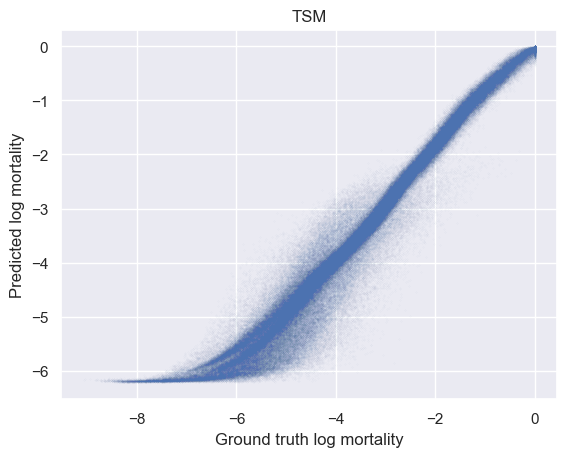

In [9]:
plt.plot(np.log(mu_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("TSM")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

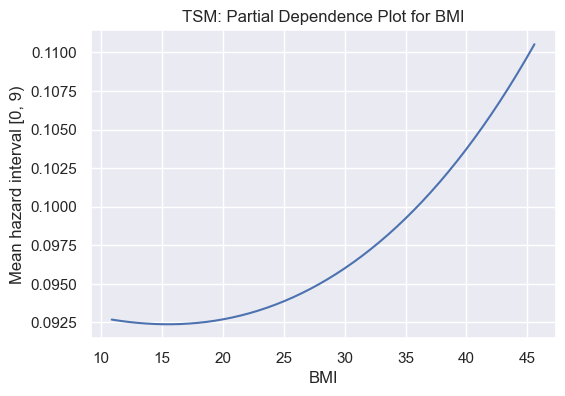

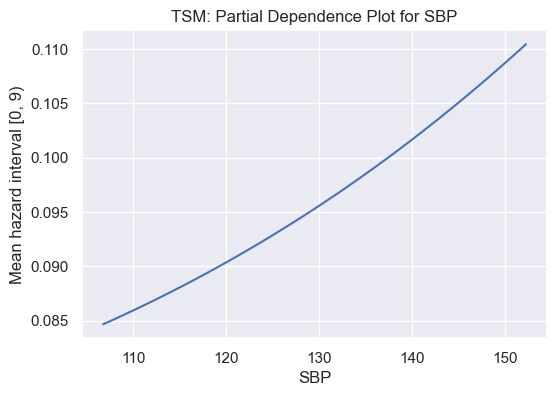

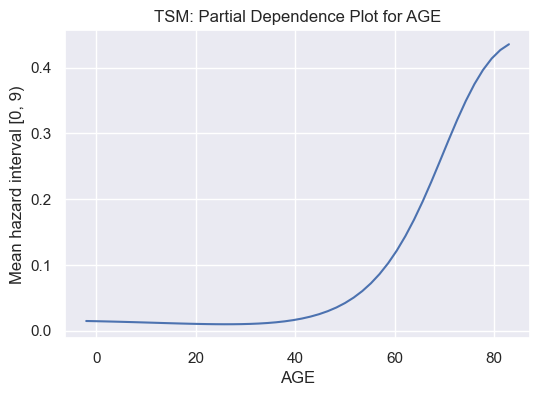

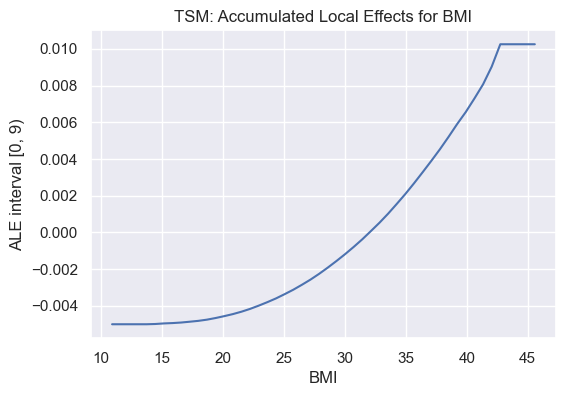

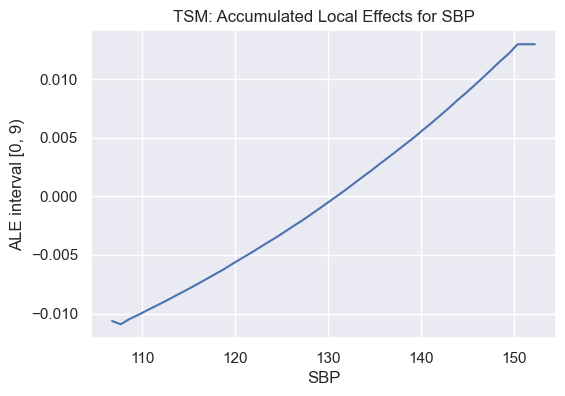

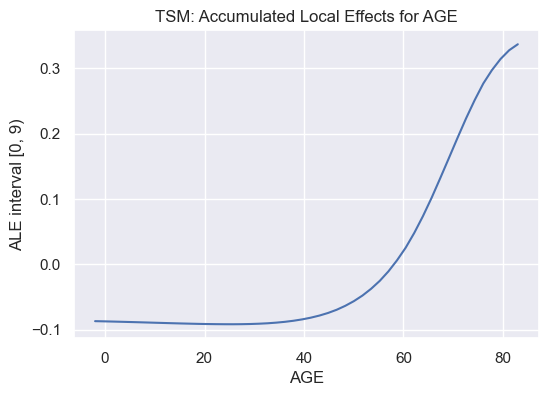

In [12]:
plot_pdp(model, X_test, 2, "BMI", bmi_range, 0, 9)
plot_pdp(model, X_test, 3, "SBP", sbp_range, 0, 9)
plot_pdp(model, X_test, 0, "AGE", age_range, 0, 9)

plot_ale(model, X_test, 2, "BMI", bmi_range, 0, 9)
plot_ale(model, X_test, 3, "SBP", sbp_range, 0, 9)
plot_ale(model, X_test, 0, "AGE", age_range, 0, 9)

In [13]:
# Note that the files loaded here are not stored on GitHub due to their size, you can create these files with the notebook "SyntheticDataset"
X_seq = np.load("data/D3_X_seq.npy")
events = np.load("data/D3_events.npy")
times = np.load("data/D3_times.npy")
mu = np.load("data/D3_mu.npy")
times = np.floor(times)

X_seq = X_seq[:,0,:]
X_seq = X_seq[:,np.newaxis,:]

bmi_range = np.linspace(np.min(X_seq[:,:,2]), np.max(X_seq[:,:,2]), 50)
sbp_range = np.linspace(np.min(X_seq[:,:,3]), np.max(X_seq[:,:,3]), 50)
age_range = np.linspace(np.min(X_seq[:,:,0]), np.max(X_seq[:,:,0]), 50)

X_seq = (X_seq - np.min(np.min(X_seq, axis = 0), axis = 0)) / (np.max(np.max(X_seq, axis = 0), axis = 0) - np.min(np.min(X_seq, axis = 0), axis = 0))

X_train, X_test, events_train, events_test, times_train, times_test, mu_train, mu_test = train_test_split(X_seq, events, times, mu, test_size=0.2, random_state=0)
X_train, X_val, events_train, events_val, times_train, times_val, mu_train, _ = train_test_split(X_train, events_train, times_train, mu_train, test_size=0.2, random_state=0)

n_samples = X_seq.shape[0]
time_steps = X_seq.shape[1]
n_features = X_seq.shape[2]

In [14]:
np.random.seed(0)
torch.manual_seed(0)

device = "cpu"
model = SurvivalTransformer(input_dim=X_seq.shape[2], time_steps=time_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
likelihood_loss = DiscreteTimeLogLikelihoodLoss()
ranking_loss = RankingLoss()
alpha = 0.3

train_dataset = SurvivalDataset(X_train, times_train, events_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataset = SurvivalDataset(X_val, times_val, events_val)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

train_losses, val_losses = [], []

start_time = time.time()
for epoch in range(1):
    model.train()
    train_loss = 0
    for X_batch, T_batch, E_batch in train_loader:
        X_batch, T_batch, E_batch = X_batch.to(device), T_batch.to(device), E_batch.to(device)

        pred = model(X_batch)
        l_lik = likelihood_loss(pred, T_batch, E_batch)
        l_rank = ranking_loss(pred, T_batch, E_batch)
        loss = l_lik + alpha * l_rank

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)

    val_loss = 0
    with torch.no_grad():
        for X_batch, T_batch, E_batch in val_loader:
            X_batch, T_batch, E_batch = X_batch.to(device), T_batch.to(device), E_batch.to(device)
    
            pred = model(X_batch)
            l_lik = likelihood_loss(pred, T_batch, E_batch)
            l_rank = ranking_loss(pred, T_batch, E_batch)
            loss = l_lik + alpha * l_rank
            
            val_loss += loss.item()
    val_losses.append(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, learning rate: {current_lr:.6f}")

    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.7

print(f"Fitting time: {time.time() - start_time:.2f} seconds")

Epoch 0, train loss: 450.0376, val loss: 107.2605, learning rate: 0.001000
Fitting time: 17431.37 seconds


In [15]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    pred_hazard = model(X_test_tensor).cpu().numpy()

time_bins = np.arange(12)
pred_time = (pred_hazard * time_bins).sum(axis=1)

y_test_struct = Surv.from_arrays(events_test.astype(bool), times_test)
c_index = concordance_index_censored(y_test_struct["event"], y_test_struct["time"], -pred_time)[0]
print(f"C-index: {c_index:.4f}")

pred_surv = 1 - np.cumsum(pred_hazard, axis=1)
pred_surv = pred_surv[:,:-1]
time_grid = np.arange(1,10)
ibs = integrated_brier_score(y_test_struct, y_test_struct, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = (events_test == True).astype(int)
p_interval = 1 - pred_surv[:, 10]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9024
Integrated Brier Score: 0.0382
Log loss for interval [0, 10): 0.1956


In [16]:
pred = 1 - pred_surv[:,10]
mse = np.mean(np.square(np.log(mu_test) - np.log(pred)))
dev = -2*np.sum(events_test*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[events_test==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    0.2984
Logistic deviance:           107713
Kullback-Leibler divergence: 30817


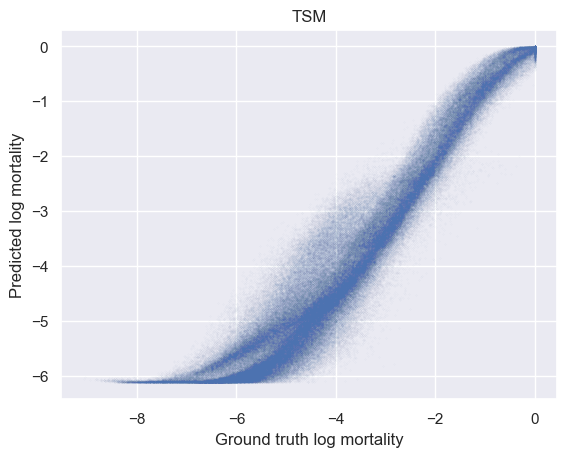

In [17]:
plt.plot(np.log(mu_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("TSM")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

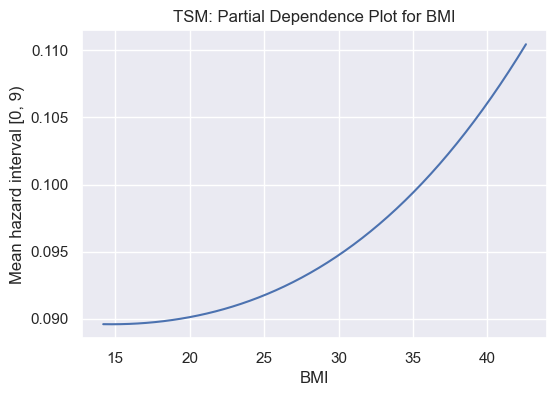

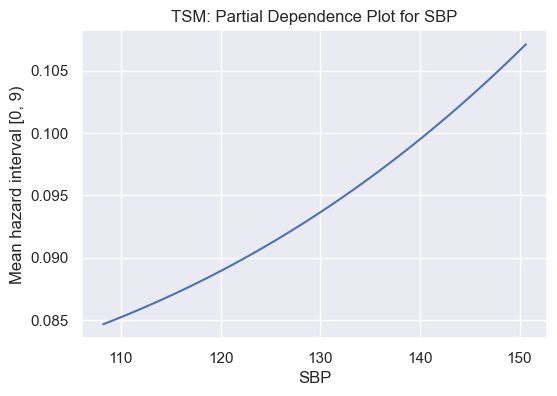

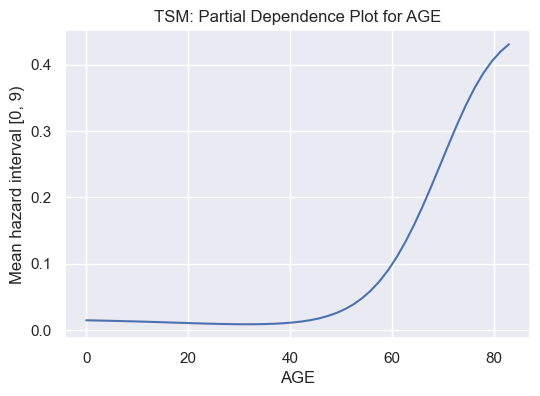

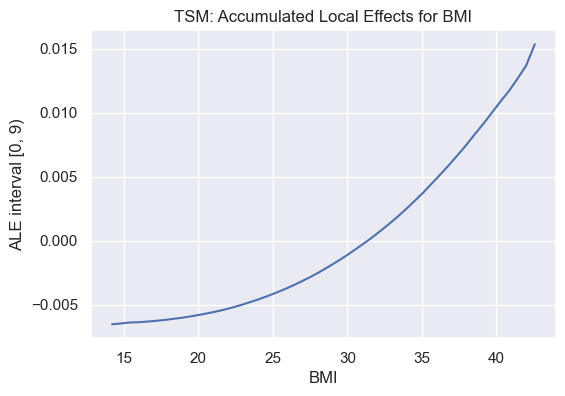

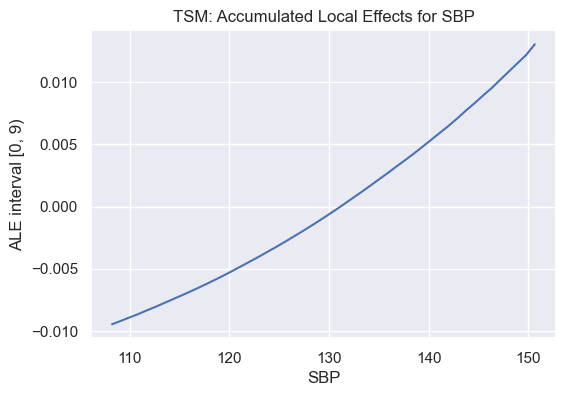

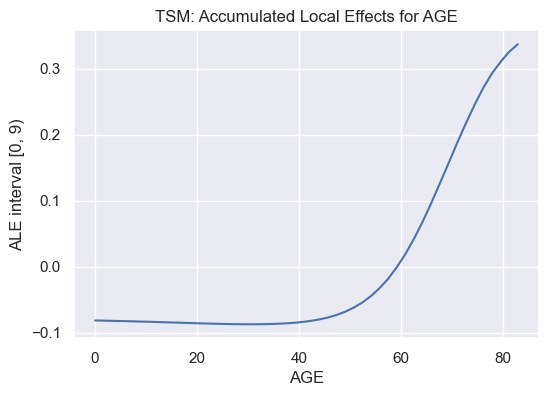

In [18]:
plot_pdp(model, X_test, 2, "BMI", bmi_range, 0, 9)
plot_pdp(model, X_test, 3, "SBP", sbp_range, 0, 9)
plot_pdp(model, X_test, 0, "AGE", age_range, 0, 9)

plot_ale(model, X_test, 2, "BMI", bmi_range, 0, 9)
plot_ale(model, X_test, 3, "SBP", sbp_range, 0, 9)
plot_ale(model, X_test, 0, "AGE", age_range, 0, 9)

In [19]:
D2 = pd.read_csv("data/D2.csv")
D2["T"] = np.floor(D2["T"])
X_D2 = D2.drop(columns=["T", "event", "mu", "BMI_scaled", "SBP_scaled", "SD_SBP_scaled", "TCL_HDL_RATIO_scaled"])
times = D2["T"].to_numpy().astype('float32')
events = D2["event"].to_numpy().astype('bool')
mu = D2["mu"].to_numpy().astype('float32')
times = np.floor(times)

X_seq = X_D2.to_numpy()[:,np.newaxis,:]

bmi_range = np.linspace(np.min(X_seq[:,:,2]), np.max(X_seq[:,:,2]), 50)
sbp_range = np.linspace(np.min(X_seq[:,:,3]), np.max(X_seq[:,:,3]), 50)
age_range = np.linspace(np.min(X_seq[:,:,0]), np.max(X_seq[:,:,0]), 50)

X_seq = (X_seq - np.min(np.min(X_seq, axis = 0), axis = 0)) / (np.max(np.max(X_seq, axis = 0), axis = 0) - np.min(np.min(X_seq, axis = 0), axis = 0))

X_train, X_test, events_train, events_test, times_train, times_test, mu_train, mu_test = train_test_split(X_seq, events, times, mu, test_size=0.2, random_state=0)
X_train, X_val, events_train, events_val, times_train, times_val, mu_train, _ = train_test_split(X_train, events_train, times_train, mu_train, test_size=0.2, random_state=0)

n_samples = X_seq.shape[0]
time_steps = X_seq.shape[1]
n_features = X_seq.shape[2]

In [20]:
np.random.seed(0)
torch.manual_seed(0)

device = "cpu"
model = SurvivalTransformer(input_dim=X_seq.shape[2], time_steps=time_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
likelihood_loss = DiscreteTimeLogLikelihoodLoss()
ranking_loss = RankingLoss()
alpha = 0.3

train_dataset = SurvivalDataset(X_train, times_train, events_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataset = SurvivalDataset(X_val, times_val, events_val)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

train_losses, val_losses = [], []

start_time = time.time()
for epoch in range(1):
    model.train()
    train_loss = 0
    for X_batch, T_batch, E_batch in train_loader:
        X_batch, T_batch, E_batch = X_batch.to(device), T_batch.to(device), E_batch.to(device)

        pred = model(X_batch)
        l_lik = likelihood_loss(pred, T_batch, E_batch)
        l_rank = ranking_loss(pred, T_batch, E_batch)
        loss = l_lik + alpha * l_rank

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)

    val_loss = 0
    with torch.no_grad():
        for X_batch, T_batch, E_batch in val_loader:
            X_batch, T_batch, E_batch = X_batch.to(device), T_batch.to(device), E_batch.to(device)
    
            pred = model(X_batch)
            l_lik = likelihood_loss(pred, T_batch, E_batch)
            l_rank = ranking_loss(pred, T_batch, E_batch)
            loss = l_lik + alpha * l_rank
            
            val_loss += loss.item()
    val_losses.append(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, learning rate: {current_lr:.6f}")

    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.7

print(f"Fitting time: {time.time() - start_time:.2f} seconds")

Epoch 0, train loss: 449.1301, val loss: 104.4957, learning rate: 0.001000
Fitting time: 16272.05 seconds


In [21]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    pred_hazard = model(X_test_tensor).cpu().numpy()

time_bins = np.arange(12)
pred_time = (pred_hazard * time_bins).sum(axis=1)

y_test_struct = Surv.from_arrays(events_test.astype(bool), times_test)
c_index = concordance_index_censored(y_test_struct["event"], y_test_struct["time"], -pred_time)[0]
print(f"C-index: {c_index:.4f}")

pred_surv = 1 - np.cumsum(pred_hazard, axis=1)
pred_surv = pred_surv[:,:-1]
time_grid = np.arange(1,10)
ibs = integrated_brier_score(y_test_struct, y_test_struct, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = (events_test == True).astype(int)
p_interval = 1 - pred_surv[:, 10]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9060
Integrated Brier Score: 0.0373
Log loss for interval [0, 10): 0.1931


In [22]:
pred = 1 - pred_surv[:,10]
mse = np.mean(np.square(np.log(mu_test) - np.log(pred)))
dev = -2*np.sum(events_test*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[events_test==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    0.2359
Logistic deviance:           106324
Kullback-Leibler divergence: 28071


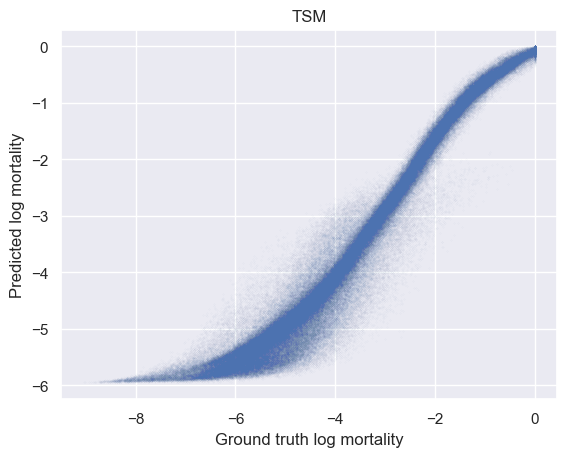

In [23]:
plt.plot(np.log(mu_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("TSM")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

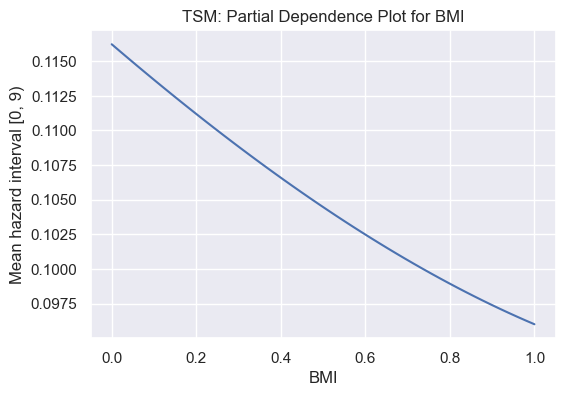

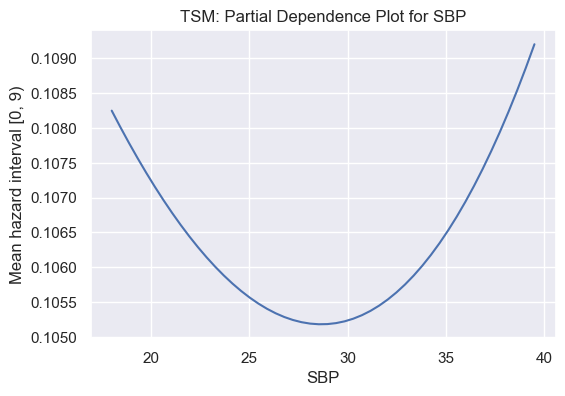

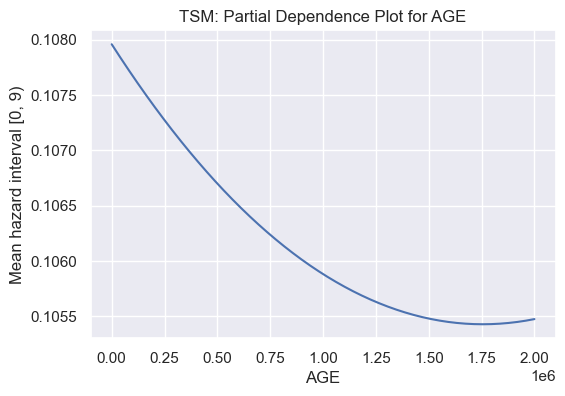

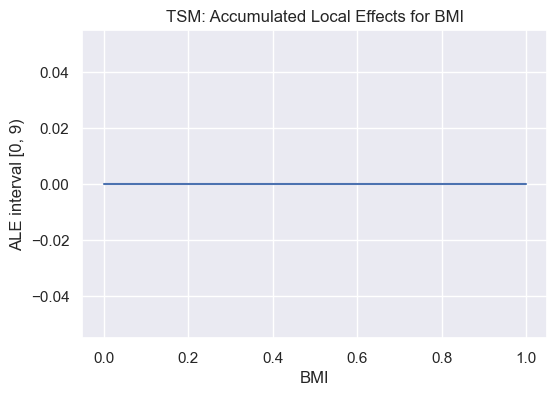

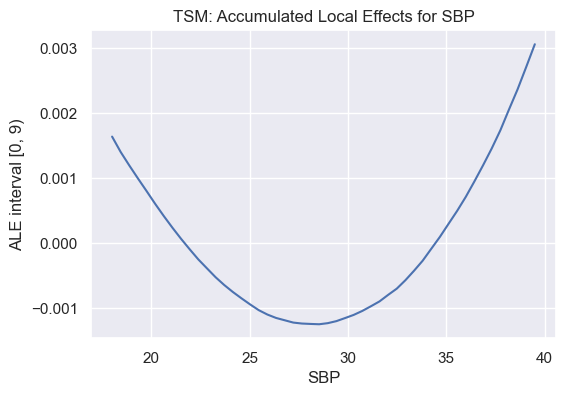

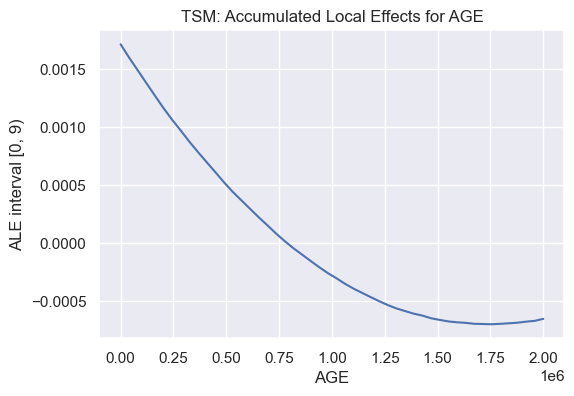

In [24]:
plot_pdp(model, X_test, 2, "BMI", bmi_range, 0, 9)
plot_pdp(model, X_test, 3, "SBP", sbp_range, 0, 9)
plot_pdp(model, X_test, 0, "AGE", age_range, 0, 9)

plot_ale(model, X_test, 2, "BMI", bmi_range, 0, 9)
plot_ale(model, X_test, 3, "SBP", sbp_range, 0, 9)
plot_ale(model, X_test, 0, "AGE", age_range, 0, 9)